# Access CESM2-LE data

In [23]:
# import packages
import intake
import xarray as xr
import numpy as np
import cupy as cp

import matplotlib.pyplot as plt

def degcos(x):
    return np.cos(x / 180 * np.pi)

In [10]:
# open catalog using the intake module
catalog = intake.open_esm_datastore("https://ncar-cesm2-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm2-le.json")

# Set filter for frequency, forcing_variant and variable
catalog_subset = catalog.search(frequency = "daily", variable =["U", "V"], forcing_variant = "cmip6")
# return a dictionary of datasets
dsets = catalog_subset.to_dataset_dict(storage_options={'anon': True}) # engine="kvikio" when I manage to install it : cuda backend

# show keys of datasets
dsets.keys()
# ds = dsets['atm.historical.daily.cmip6']
historical_cmip6 = dsets['atm.historical.daily.cmip6']
future_cmip6 = dsets['atm.ssp370.daily.cmip6']

ds = xr.concat([historical_cmip6, future_cmip6], dim='time')
# ds = ds.isel(member_id=np.delete(np.arange(50), np.arange(0, 50, 5))) # dont want the "first ten"
# ds = ds.isel(lon=np.append(np.arange(10), np.arange(230, len(ds.lon)))).isel(lat=np.arange(107, 182)) # na sector
ods = ds.copy()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


c:\ProgramData\Miniconda3\envs\rcc\lib\site-packages\dask\array\core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 50
  result = blockwise(


In [11]:
ds = ds.roll(lon=144, roll_coords=True)
a = np.array(ds["lon"])
a[:144] = - 360 + a[:144]
ds["lon2"] = xr.DataArray(a, coords={"lon": ds["lon"]})

In [12]:
ds = ds.swap_dims({"lon": "lon2"})
ds = ds.drop("lon")
ds = ds.rename({"lon2": "lon"})
ds = ds.isel(lon=np.arange(90, 160)).isel(lat=np.arange(107, 182))

In [24]:
a = 6.371e6
newds = ds.isel(lev=25, time=0, member_id=0)
newds["vort"] = (newds["V"].differentiate("lon") - (newds["U"] * degcos(newds["lat"])).differentiate("lat")) / a / degcos(newds["lat"])
newds["vort"].attrs["long_name"] = "vorticity"
newds["vort"].attrs["units"] = "1/s"

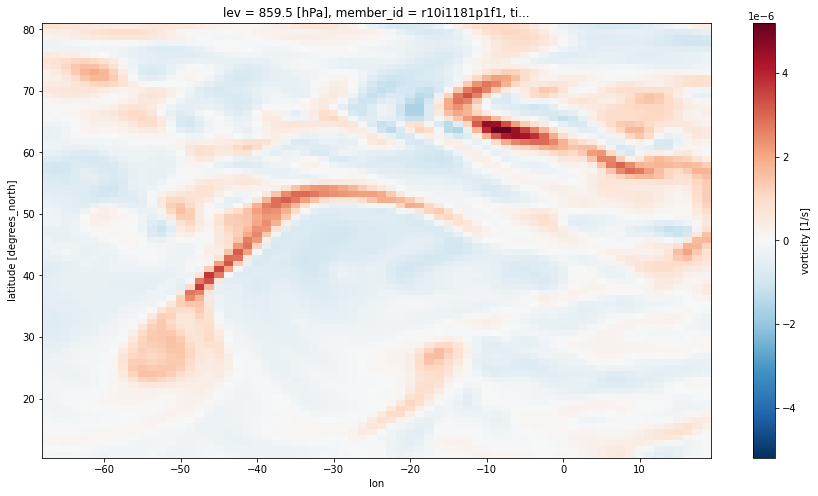

In [26]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
newds["vort"].plot(ax=ax)

In [27]:
ds["U"]

<xarray.DataArray 'U' (member_id: 50, time: 91615, lev: 32, lat: 75, lon: 70)>
dask.array<getitem, shape=(50, 91615, 32, 75, 70), dtype=float64, chunksize=(1, 10, 32, 75, 70), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 10.84 11.78 12.72 13.66 ... 77.75 78.69 79.63 80.58
  * lev        (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
  * time       (time) object 1850-01-01 12:00:00 ... 2100-12-31 12:00:00
  * lon        (lon) float64 -67.5 -66.25 -65.0 -63.75 ... 15.0 16.25 17.5 18.75
Attributes:
    cell_methods:  time: mean
    long_name:     Zonal wind
    mdims:         1
    units:         m/s